<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRA1: Deep Reinforcement Learning

#### AUTOR: Mario Ubierna San Mamés
 

En esta práctica se hará un estudio sobre el entorno **highway-env**, donde inicialmente se realizará una exploración sobre el entorno, posteriormente implementaremos un agente DQN y finalmente mejoraremos el primer agente implementado

## 0. Contexto

**Highway-env** es un problema de conducción autónoma, donde tenemos múltiples carriles y varios coches transitando. Nuestro objetivo es que el agente sea capaz de controlar el vehículo con el fin de:

- Evitar colisiones con otros vehículos.
- Tener la máxima velocidad posible.
- Mantenerse en el carril derecho lo más posible.

El entorno se considera superado cuando en el tiempo de observación máximo establecido, se han verificado las tres condiciones anteriores.

![Alt Text](https://raw.githubusercontent.com/eleurent/highway-env/gh-media/docs/media/highway-env.gif?raw=true)

## 1. Entorno

Lo primero de todo es cargar las librerías necesarias:

In [1]:
import gym
import highway_env
from collections import namedtuple, deque
from copy import deepcopy, copy
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
import time

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.1 (0.5 ptos) - </strong> Exploración del entorno y representación de una ejecución aleatoria:
</div>

#### Exploración del entorno

Carga del entorno:

In [2]:
# Definimos el entorno
env = gym.make("highway-v0")

Información básica del entorno:

In [3]:
print("El espacio de acciones es {} ".format(env.action_space))
print("La dimensión del espacio de acciones es: {}".format(env.action_space.n))
# print("Las acciones por defecto son {}".format(str(env.action_type.actions_indexes)))
print("El espacio de observaciones es {} ".format(env.observation_space))
print("La dimensión del espacio de estados: {}".format(env.observation_space.shape[0]))
print("El rango de recompensas es {} ".format(env.reward_range))

El espacio de acciones es Discrete(5) 
La dimensión del espacio de acciones es: 5
El espacio de observaciones es Box([[-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf]], [[inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]
 [inf inf inf inf inf]], (5, 5), float32) 
La dimensión del espacio de estados: 5
El rango de recompensas es (-inf, inf) 


De la anterior ejecución podemos observar que, por defecto tanto la dimensión del espacio de acciones como de estados es 5. Estos valores vienen predefinidos a la hora de cargar el entorno **highway-v0**.  
  
Para saber más sobre la configuración por defecto del entorno ejecutamos la siguiente instrucción:

In [4]:
env.env.default_config()

{'observation': {'type': 'Kinematics'},
 'action': {'type': 'DiscreteMetaAction'},
 'simulation_frequency': 15,
 'policy_frequency': 1,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 150,
 'centering_position': [0.3, 0.5],
 'scaling': 5.5,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'lanes_count': 4,
 'vehicles_count': 50,
 'controlled_vehicles': 1,
 'initial_lane_id': None,
 'duration': 40,
 'ego_spacing': 2,
 'vehicles_density': 1,
 'collision_reward': -1,
 'right_lane_reward': 0.1,
 'high_speed_reward': 0.4,
 'lane_change_reward': 0,
 'reward_speed_range': [20, 30],
 'offroad_terminal': False}

Como podemos ver obtenemos la siguiente información:  
- El tipo de observación es Kinematics, esto lo que significa es que el espacio de estados va a ser una matriz del tipo VxF, donde V es el número de vehículos cercanos a nuestro coche y F el número de características (['presence', 'x', 'y', 'vx', 'vy']).

- El tipo de acciones es DiscreteMetaAction, en este caso hay 5 acciones. La primera es movernos al carril de la izquierda "0", la segunda es un movimiento ilegal o mantenernos en el carril actual a la velocidad actual "1" (cuando se produce un cambio de carril en el límite de la carretera, o cuando la acelaración o desaceleración es mayor o menor que la velocidad máxima/mínima) "1", la tercera es movernos al carril de la derecha "2", la cuarta es aumentar la velocidad "3" y la quinta reducir la velocidad "4".

- El número de carriles es 4, se puede modificar para añadir más o menos.

- El número de vehículos es 50 y al igual que antes se puede modificar.

- La recompensa por colisión es -1.

- La recompensa por estar en el carril de la derecha es 0.1.

- La recompensa por alcanzar una alta velocidad es 0.4.

- La recompensa por cambiar de carril es 0.

- Y la recompensa por aumentar o disminuir la velocidad varía entre 20 y 30 dependiendo de forma lineal a su velocidad.

A continuación podemos ver un ejemplo de una acción tomada aleatoriamente y todas las posibles acciones que podemos tomar:

In [5]:
print("Acción aleatoria tomada {}".format(env.action_space.sample()))
print("Las posibles acciones son {}".format(env.action_type.actions_indexes))

Acción aleatoria tomada 3
Las posibles acciones son {'LANE_LEFT': 0, 'IDLE': 1, 'LANE_RIGHT': 2, 'FASTER': 3, 'SLOWER': 4}


Para concluir con la exploración del entorno, vamos a mostrar un ejemplo de un estado según el espacio de observaciones por defecto junto el nombre de cada columna:

In [6]:
print("Un estado aleatorio sería \n{}".format(env.observation_space.sample()))
print("El nombre de cada columna (característica \"F\") es {}".format(env.env.observation_type.features))

Un estado aleatorio sería 
[[-1.1733414   0.8214814  -0.80610216  0.76553327 -0.38065767]
 [-1.056786   -1.3827056   1.5724442   0.51160705  0.6249763 ]
 [-0.09564952 -2.1438923   0.1138035   0.5097114  -1.4345912 ]
 [-1.224389   -1.224379   -0.8586749   1.5297394   0.48134953]
 [-1.6447053  -0.3417162  -0.11180802  1.4682747  -0.37738755]]
El nombre de cada columna (característica "F") es ['presence', 'x', 'y', 'vx', 'vy']


#### Representación de una ejecución aleatoria

Obs inicial:


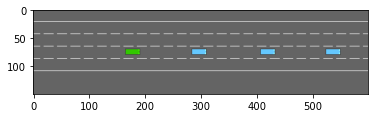

[[ 1.          0.8815729   0.5         0.3125      0.        ]
 [ 1.          0.10787347  0.         -0.03381135  0.        ]
 [ 1.          0.21976268  0.         -0.02719073  0.        ]
 [ 1.          0.3256862   0.         -0.03370362  0.        ]
 [ 1.          0.4223269  -0.5        -0.02688401  0.        ]]

Acción: SLOWER -> recommpensa: 0.7338962090612631
Nuevo estado:


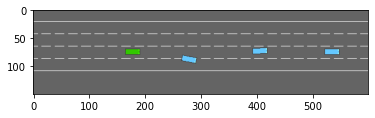

[[ 1.          0.99400955  0.5         0.26068053  0.        ]
 [ 1.          0.09217243  0.16966484 -0.04157917  0.04134007]
 [ 1.          0.20802286 -0.0101804  -0.03891837 -0.0144693 ]
 [ 1.          0.3237823   0.          0.01292874  0.        ]
 [ 1.          0.4103214  -0.4628314  -0.04293691  0.03372232]]

Acción: IDLE -> recommpensa: 0.7150048162755963
Nuevo estado:


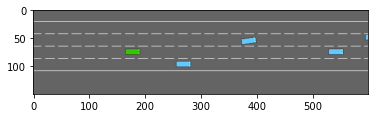

[[ 1.          1.          0.5         0.25182518  0.        ]
 [ 1.          0.08222678  0.25929826 -0.01181212  0.00502398]
 [ 1.          0.18955436 -0.21538171 -0.04578713 -0.02921698]
 [ 1.          0.33032623  0.          0.0179214   0.        ]
 [ 1.          0.39155158 -0.27068168 -0.04392809  0.02359902]]

Acción: LANE_LEFT -> recommpensa: 0.6895542772906024
Nuevo estado:


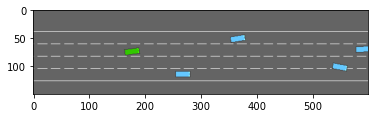

[[ 1.0000000e+00  1.0000000e+00  2.9147089e-01  2.4811305e-01
  -3.3105284e-02]
 [ 1.0000000e+00  8.1631139e-02  4.6282059e-01  4.4030967e-04
   3.1143505e-02]
 [ 1.0000000e+00  1.7127727e-01 -2.5923863e-01 -3.6292687e-02
  -1.1523308e-03]
 [ 1.0000000e+00  3.3802813e-01  3.2310051e-01  1.4477982e-02
   8.2557268e-02]
 [ 1.0000000e+00  3.7586880e-01 -4.4728275e-02 -4.1051414e-02
   1.7936632e-02]]

Acción: SLOWER -> recommpensa: 0.6890025959381983
Nuevo estado:


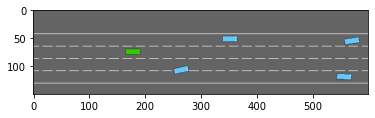

[[ 1.0000000e+00  1.0000000e+00  2.3879448e-01  2.5005248e-01
  -6.3974957e-04]
 [ 1.0000000e+00  7.9121195e-02  3.7837589e-01 -1.1142156e-02
  -4.7786996e-02]
 [ 1.0000000e+00  1.5782867e-01 -2.5077650e-01 -3.6888864e-02
   9.5045235e-04]
 [ 1.0000000e+00  3.4439752e-01  5.1665312e-01  1.7782930e-02
   1.1172858e-02]
 [ 1.0000000e+00  3.5712764e-01 -2.0564373e-01 -4.2340819e-02
  -2.9709512e-02]]

Acción: LANE_RIGHT -> recommpensa: 0.7111305423080322
Nuevo estado:


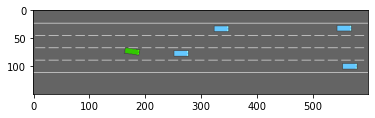

[[ 1.          1.          0.456647    0.24759574  0.03465402]
 [ 1.          0.07906286  0.03600151  0.00177809 -0.04314566]
 [ 1.          0.14389776 -0.4585384  -0.03754587 -0.03313318]
 [ 1.          0.34404197 -0.46641156 -0.02972633 -0.03514479]
 [ 1.          0.3533309   0.30030018  0.02120322 -0.03702874]]

Acción: SLOWER -> recommpensa: 0.7111144316740498
Nuevo estado:


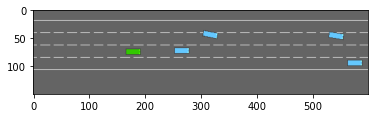

[[ 1.0000000e+00  1.0000000e+00  5.1174796e-01  2.5000069e-01
   6.6325738e-04]
 [ 1.0000000e+00  7.9504177e-02 -1.7667588e-02  2.0387166e-03
   1.5762208e-03]
 [ 1.0000000e+00  1.2652911e-01 -3.3355162e-01 -4.3394137e-02
   4.0595829e-02]
 [ 1.0000000e+00  3.3102041e-01 -3.1286037e-01 -2.5601428e-02
   3.6932841e-02]
 [ 1.0000000e+00  3.6111352e-01  2.3806587e-01  1.9313466e-02
  -1.2270667e-03]]

Acción: FASTER -> recommpensa: 0.821659913939431
Nuevo estado:


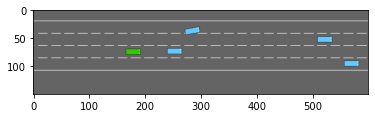

[[ 1.          1.          0.5021135   0.30181485 -0.00171812]
 [ 1.          0.06816747 -0.00186623 -0.04768839  0.00217586]
 [ 1.          0.0977678  -0.4098305  -0.08904509 -0.03836971]
 [ 1.          0.3118282  -0.24022913 -0.06138324  0.00327805]
 [ 1.          0.3563482   0.24753183 -0.03214739  0.00183129]]

Acción: LANE_LEFT -> recommpensa: 0.818328614027435
Nuevo estado:


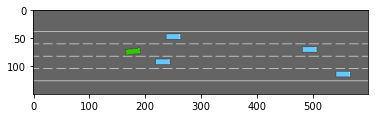

[[ 1.          1.          0.29005662  0.3088029  -0.03405354]
 [ 1.          0.04846952  0.21023986 -0.05312122  0.03395183]
 [ 1.          0.06587902 -0.2965352  -0.0740725   0.02713593]
 [ 1.          0.28803894 -0.03724441 -0.06000258  0.03223588]
 [ 1.          0.34261113  0.4599483  -0.0388721   0.03408356]]

Acción: SLOWER -> recommpensa: 0.7110086150083079
Nuevo estado:


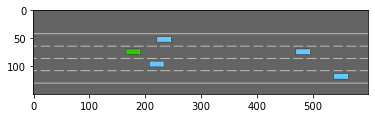

[[ 1.0000000e+00  1.0000000e+00  2.3893723e-01  2.6036862e-01
  -3.7524471e-05]
 [ 1.0000000e+00  3.9012976e-02  2.6105598e-01 -3.5929268e-03
   1.3160140e-05]
 [ 1.0000000e+00  5.0427612e-02 -2.4376288e-01 -1.2704033e-02
   1.9033640e-03]
 [ 1.0000000e+00  2.7664295e-01  1.0523403e-02 -6.5348009e-03
  -6.9003218e-05]
 [ 1.0000000e+00  3.3867660e-01  5.1108080e-01  9.7720651e-03
   3.2165004e-05]]

Acción: LANE_LEFT -> recommpensa: 0.6704466676136279
Nuevo estado:


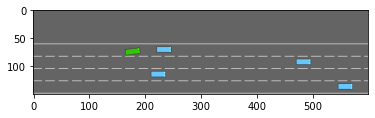

[[ 1.          1.          0.04059284  0.24977331 -0.0316603 ]
 [ 1.          0.04108742  0.4593924   0.00772118  0.03166489]
 [ 1.          0.05040331 -0.04034948  0.00626696  0.03203028]
 [ 1.          0.27797636  0.20925723  0.00685884  0.03174853]
 [ 1.          0.34598583  0.70940715  0.02054434  0.03165871]]

Acción: FASTER -> recommpensa: 0.7778608597385593
Nuevo estado:


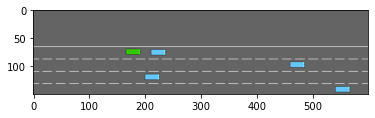

[[ 1.0000000e+00  1.0000000e+00 -1.4162919e-02  3.0212218e-01
  -2.5533355e-04]
 [ 1.0000000e+00  3.1402800e-02  5.1416302e-01 -4.4194736e-02
   2.5661691e-04]
 [ 1.0000000e+00  4.1099824e-02  1.4411920e-02 -4.0911064e-02
   1.6639353e-04]
 [ 1.0000000e+00  2.6815379e-01  2.6418704e-01 -4.4098329e-02
   2.6207970e-04]
 [ 1.0000000e+00  3.4137121e-01  7.6416200e-01 -3.1648815e-02
   2.5558556e-04]]

Acción: IDLE -> recommpensa: 0.08491640436369992
Nuevo estado:


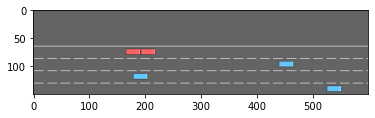

[[ 1.          1.         -0.00248994  0.2897975   0.00202166]
 [ 1.          0.01256832  0.5024907  -0.03164383 -0.00202187]
 [ 1.          0.0250342   0.00255722 -0.0432947  -0.00204402]
 [ 1.          0.24943148  0.2524978  -0.03123855 -0.00202591]
 [ 1.          0.3275339   0.7524899  -0.01918298 -0.00202158]]
Episodio terminado después de 12 pasos y la recompensa fue 8.133923947238802


In [7]:
obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = env.action_space.sample()
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    env.close()
    print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 1.2 (0.5 ptos) - </strong> Explicar los diferentes espacios de observaciones y de acciones:
</div>

Resuelto en el informe

## 2. Agente de referencia

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.1 (1.5 ptos) - </strong> Implementar un agente DQN con la observación kinematics
</div>

Lo primero de todo es definir la clase que nos va a permitir crear el replay buffer:

In [11]:
class experienceReplayBuffer:

    def __init__(self, memory_size=50000, burn_in=10000):
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.buffer = namedtuple('Buffer', 
            field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.replay_memory = deque(maxlen=memory_size)

    def sample_batch(self, batch_size=32):
        samples = np.random.choice(len(self.replay_memory), batch_size, 
                                   replace=False)
        # Use asterisk operator to unpack deque 
        batch = zip(*[self.replay_memory[i] for i in samples])
        return batch

    def append(self, state, action, reward, done, next_state):
        self.replay_memory.append(
            self.buffer(state, action, reward, done, next_state))

    def burn_in_capacity(self):
        return len(self.replay_memory) / self.burn_in

Posteriormente tenemos que crear la red neuronal:

In [12]:
class NeuralNet(torch.nn.Module):  

    def __init__(self, env, learning_rate=1e-3):
        
        """
        Params
        ======
        n_inputs: tamaño del espacio de estadps
        n_outputs: tamaño del espacio de acciones
        actions: array de acciones posibles
        """
        ######################################
        ##TODO: Inicializar parámetros
        super(NeuralNet, self).__init__()
        self.n_inputs = env.observation_space.shape[0]
        self.n_outputs = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate
        
        #######################################
        ##TODO: Neural network
        self.model = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(128, self.n_outputs, bias=True),
        )
        
        #######################################
        ##TODO: Initialize optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)


    ### e-greedy method
    def get_action(self, state, epsilon=0.05):
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)  # acción random
        else:
            qvals = self.get_qvals(state)  # acción del cálculo de Q para esta acción
#             print(state)
#             print(qvals)
#             print(state[0])
#             print(self.get_qvals(state[0]))
#             action= torch.max(qvals, dim=-1)[1].item()
            action= torch.max(qvals[0], dim=-1)[1].item()
#             print(action)
        return action
    
    
    def get_qvals(self, state):
        if type(state) is tuple:
#             print("*******************")
#             print("ACTUALIZCION")
#             print(state)
#             state = np.array([np.ravel(s) for s in state])
#             print(state)
#             print("*******************")
            lista = []
            for s in state:
                lista.append(s[0])
            state = np.array(lista)
        state_t = torch.FloatTensor(state)
        return self.model(state_t)  

Luego tenemos que crear el agente:

In [13]:
class DQNAgent:
    
    ######################################
    ##TODO 1: Declarar variables
    def __init__(self, env, main_network, buffer, epsilon=0.1, eps_decay=0.99, batch_size=32):
        
        self.env = env
        self.main_network = main_network
        self.target_network = deepcopy(main_network) 
        self.buffer = buffer
        self.epsilon = epsilon
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.nblock = 100 # bloque de los X últimos episodios de los que se calculará la media de recompensas
        self.initialize()
        
    ######################################
    ##TODO 2: Inicializar otras variables necesarias
    def initialize(self):
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
        self.history_loss = []
        self.update_epsilon = []
        self.sync_eps = []
        self.total_reward = 0
        self.step_count = 0
        self.state0 = self.env.reset()
    
    ######################################
    ##TODO 3: Tomar paso siguiente
    def take_step(self, eps, mode='train'):
        if mode == 'explore': 
            action = self.env.action_space.sample()  # acción aleatoria en el burn-in
        else:
            action = self.main_network.get_action(self.state0, eps) # acción a partir del valor de Q (elección de la acción con mejor Q)
            self.step_count += 1
            
        #TODO: tomar 'step' i obtener nuevo estado y recompensa. Guardar la experiencia en el buffer
        new_state, reward, done, _ = self.env.step(action)
        self.total_reward += reward
        self.buffer.append(self.state0, action, reward, done, new_state)
        self.state0 = new_state.copy()
        
        #TODO: resetear entorno 'if done'
        if done:
            self.state0 = self.env.reset()
        return done

    ## TRAINING
    def train(self, gamma=0.99, max_episodes=50000, 
              batch_size=32,
              dnn_update_frequency=4,
              dnn_sync_frequency=2000):
        
        self.gamma = gamma

        # Rellenamos el buffer con N experiencias aleatorias ()
        print("Filling replay buffer...")
        while self.buffer.burn_in_capacity() < 1:
            self.take_step(self.epsilon, mode='explore')

            
        episode = 0
        training = True
        print("Training...")
        while training:
            self.state0 = self.env.reset()
            self.total_reward = 0
            gamedone = False
            while gamedone == False:
                # El agente toma una acción
                gamedone = self.take_step(self.epsilon, mode='train')
                
                #################################################################################
                #####TODO 4:  Actualizar la red principal según la frecuencia establecida #######
                if self.step_count % dnn_update_frequency == 0:
                    self.update()
                    
                ########################################################################################
                ###TODO 6: Sincronizar red principal y red objetivo según la frecuencia establecida#####
                if self.step_count % dnn_sync_frequency == 0:
                    self.target_network.load_state_dict(
                        self.main_network.state_dict()
                    )
                    self.sync_eps.append(episode)
                
                if gamedone:                   
                    episode += 1
                    
                    # Guardamos la evolución de la pérdida
                    self.history_loss.append(np.mean(self.update_loss))
                        
                    self.update_loss = []
                                    
                    #######################################################################################
                    ###TODO 7: calcular la media de recompensa de los últimos X episodios, y almacenar
                    self.training_rewards.append(self.total_reward)
                    mean_rewards = np.mean(
                        self.training_rewards[-self.nblock:]
                    )
                    self.mean_training_rewards.append(mean_rewards)

                    self.update_epsilon.append(self.epsilon) # Guardamos la evolución de epsilon
                    
                    print("\rEpisode {:d} Mean Rewards {:.2f} Epsilon {}\t\t".format(
                        episode, mean_rewards, self.epsilon), end="")
                    
                    #######################################################################################
                    ### TODO 8: Comprobar que todavía quedan episodios. Parar el aprendizaje si se llega al límite
                    if episode >= max_episodes:
                        training = False
                        print('\nEpisode limit reached')
                        break
                    
                    #Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego  
#                     if mean_rewards >= self.reward_threshold:
#                         training = False
#                         print('\nEnvironment solved in {} episodes!'.format(
#                             episode))
#                         break
                    
                    #################################################################################
                    ######TODO 9: Actualizar epsilon según la velocidad de decaimiento fijada########
                    self.epsilon = max(self.epsilon * self.eps_decay, 0.01)

                    
    #####################################         
    #####TODO 5: cálculo de la pérdida###
    def calculate_loss(self, batch):
        # Separamos las variables de la experiencia y las convertimos a tensores 
        states, actions, rewards, dones, next_states = [i for i in batch] 
        rewards_vals = torch.FloatTensor(rewards)
        actions_vals = torch.LongTensor(np.array(actions)).reshape(-1,1)
        dones_t = torch.ByteTensor(dones)
        
#         print(states)
#         print("*******************")
#         print(actions)
#         print("*******************")
#         print(actions_vals)
#         print("*******************")
#         aux1 = self.main_network.get_qvals(states) 
#         print(aux1)
        
        # Obtenemos los valores de Q de la red principal
        qvals = torch.gather(self.main_network.get_qvals(states), 1, actions_vals)
#         print(qvals)
        # Obtenemos los valores de Q objetivo. El parámetro detach() evita que estos valores actualicen la red objetivo
        qvals_next = torch.max(self.target_network.get_qvals(next_states),
                               dim=-1)[0].detach()
        qvals_next[dones_t] = 0 # 0 en estados terminales
        
        #################################################################################
        ### TODO: Calcular ecuación de Bellman
        expected_qvals = self.gamma * qvals_next + rewards_vals
        
        #################################################################################
        ### TODO: Calcular la pérdida (MSE)
        loss = torch.nn.MSELoss()(qvals, expected_qvals.reshape(-1,1))
        
        return loss

    
    def update(self):
        self.main_network.optimizer.zero_grad()  # eliminamos cualquier gradiente pasado
        batch = self.buffer.sample_batch(batch_size=self.batch_size) # seleccionamos un conjunto del buffer
        loss = self.calculate_loss(batch) # calculamos la pérdida
        loss.backward() # hacemos la diferencia para obtener los gradientes
        self.main_network.optimizer.step() # aplicamos los gradientes a la red neuronal
        # Guardamos los valores de pérdida
        self.update_loss.append(loss.detach().numpy())
        
    def plot_rewards(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.training_rewards, label='Rewards')
        plt.plot(self.mean_training_rewards, label='Mean Rewards')
        plt.title("Evolución de las recompensas")
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(loc="upper left")
        plt.show()
        
    def plot_loss(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.history_loss)
        plt.title("Evolución de la pérdida")
        plt.xlabel('Episode')
        plt.ylabel('Loss')
        plt.show()
        
    def plot_epsilon(self):
        plt.figure(figsize=(12,8))
        plt.plot(self.update_epsilon)
        plt.title("Evolución de epsilon")
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        plt.show()

<div style="background-color: #grey; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio 2.2 (1 ptos) - </strong> Entrenar el agente y buscar los hiperparámetros óptimos:
</div>

In [26]:
# Definición de los hiperparámetros
# lr = 0.001            # Velocidad de aprendizaje
# BATCH_SIZE = 32       # Tamaño del batch
# MAX_EPISODES = 1500   # Número de episodios
# BURN_IN = 100        # Número de episodios para rellenar el buffer
# DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
# DNN_SYNC = 1000       # Frecuencia de sincronización con la red objetivo
# MEMORY_SIZE = 10000   # Capacidad máxima del buffer
# GAMMA = 0.99          # Factor de descuento
# EPSILON = 1           # Epsilon
# EPSILON_DECAY = 0.99   # Decaimiento de epsilon
# lr = 0.001            # Velocidad de aprendizaje
# BATCH_SIZE = 32       # Tamaño del batch
# MAX_EPISODES = 5000   # Número de episodios
# BURN_IN = 1        # Número de episodios para rellenar el buffer
# DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
# DNN_SYNC = 1000       # Frecuencia de sincronización con la red objetivo
# MEMORY_SIZE = 10   # Capacidad máxima del buffer
# GAMMA = 0.99          # Factor de descuento
# EPSILON = 0.01           # Epsilon
# EPSILON_DECAY = 0.99   # Decaimiento de epsilon
lr = 0.001            # Velocidad de aprendizaje
BATCH_SIZE = 32       # Tamaño del batch
MAX_EPISODES = 4000   # Número de episodios
BURN_IN = 1000        # Número de episodios para rellenar el buffer
DNN_UPD = 3           # Frecuencia de actualización de la red neuronal
DNN_SYNC = 500       # Frecuencia de sincronización con la red objetivo
MEMORY_SIZE = 10000   # Capacidad máxima del buffer
GAMMA = 0.8          # Factor de descuento
EPSILON = 1           # Epsilon
EPSILON_DECAY = 0.99   # Decaimiento de epsilon

In [27]:
# Carga de la red neuronal
dqn = NeuralNet(env, learning_rate=lr)

# Creación del buffer
buffer = experienceReplayBuffer(
    memory_size=MEMORY_SIZE, 
    burn_in=BURN_IN
)

# Creación del agente
agent_dqn = DQNAgent(
    env=env,
    main_network=dqn,
    buffer=buffer,
    epsilon=EPSILON,
    eps_decay=EPSILON_DECAY,
    batch_size=BATCH_SIZE
)

# Entrenamos el agente
agent_dqn.train(
    gamma=GAMMA, 
    max_episodes=MAX_EPISODES, 
    batch_size=BATCH_SIZE,  
    dnn_update_frequency=DNN_UPD, 
    dnn_sync_frequency=DNN_SYNC
)

Filling replay buffer...
Training...


<ipython-input-13-018314396d97>:152: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen\native\TensorAdvancedIndexing.cpp:1273.)
  qvals_next[dones_t] = 0 # 0 en estados terminales


Episode 4000 Mean Rewards 17.28 Epsilon 0.01		118606165716			
Episode limit reached


In [28]:
# Guardamos el modelo entrenado
trained_model = {
    "state_dic" : agent_dqn.main_network.state_dict()
}
torch.save(trained_model, "DQN.pth")

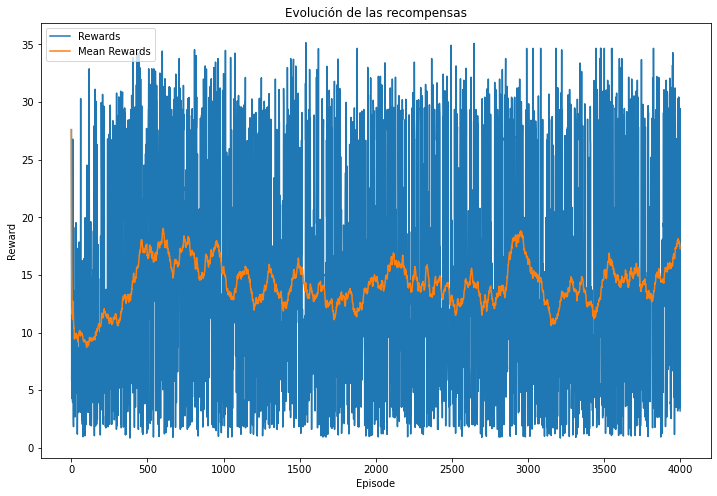

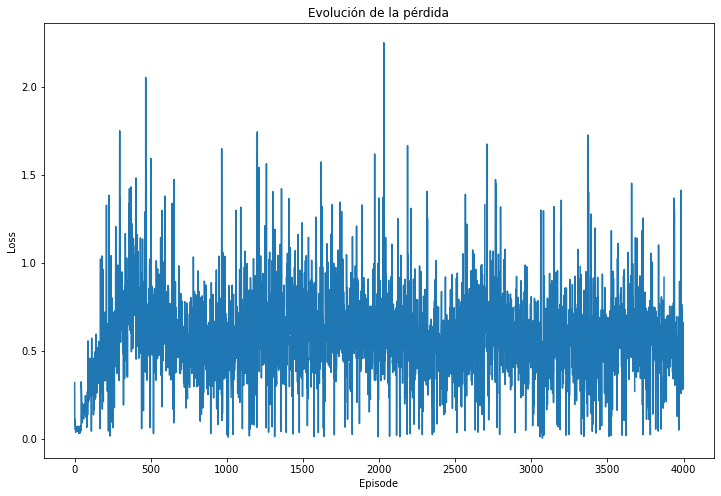

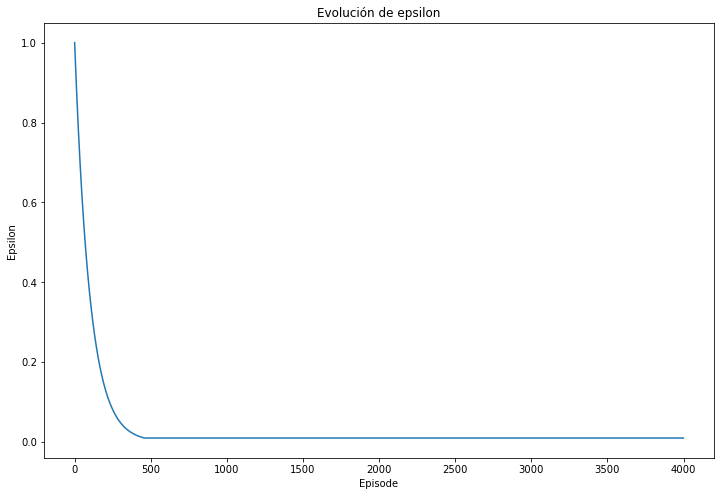

In [29]:
agent_dqn.plot_rewards()
agent_dqn.plot_loss()
agent_dqn.plot_epsilon()

Obs inicial:


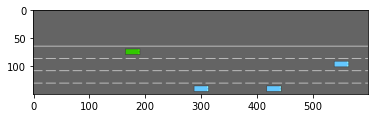

[[ 1.          0.8781411   0.          0.3125      0.        ]
 [ 1.          0.11092122  0.75       -0.03453687  0.        ]
 [ 1.          0.2293577   0.75       -0.01524639  0.        ]
 [ 1.          0.33966717  0.25       -0.01733499  0.        ]
 [ 1.          0.4464205   0.25       -0.04309437  0.        ]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


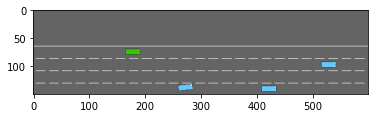

[[ 1.          1.          0.          0.3125      0.        ]
 [ 1.          0.08604888  0.7278991  -0.0825452  -0.02561245]
 [ 1.          0.22158484  0.75       -0.02429734  0.        ]
 [ 1.          0.3186956   0.26372427 -0.09220459 -0.00199215]
 [ 1.          0.4230957   0.4229671  -0.06856874  0.0417182 ]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


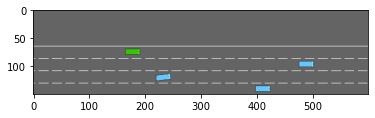

[[ 1.          1.          0.          0.3125      0.        ]
 [ 1.          0.05043538  0.52532005 -0.08447975 -0.02698438]
 [ 1.          0.21103926  0.75       -0.02857117  0.        ]
 [ 1.          0.28183717  0.25121328 -0.08296944 -0.0015896 ]
 [ 1.          0.3953777   0.5092215  -0.07107279  0.00419075]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


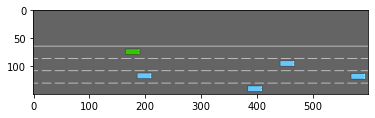

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00  1.8709933e-02  4.8981899e-01 -7.5404309e-02
   3.9802759e-04]
 [ 1.0000000e+00  1.9897331e-01  7.5000000e-01 -3.1792749e-02
   0.0000000e+00]
 [ 1.0000000e+00  2.5147280e-01  2.4933760e-01 -6.8843573e-02
   6.2582178e-05]
 [ 1.0000000e+00  3.6655286e-01  5.0381273e-01 -7.2831921e-02
  -1.8192478e-03]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


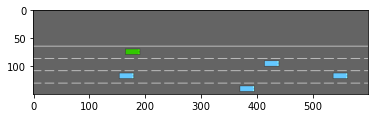

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00 -1.0537153e-02  4.9851727e-01 -7.0922375e-02
   1.2978546e-03]
 [ 1.0000000e+00  1.8580717e-01  7.5000000e-01 -3.4051977e-02
   0.0000000e+00]
 [ 1.0000000e+00  2.2579344e-01  2.4992570e-01 -5.9638772e-02
   7.9658770e-05]
 [ 1.0000000e+00  3.3735076e-01  4.9967042e-01 -7.3018529e-02
  -2.4690060e-04]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


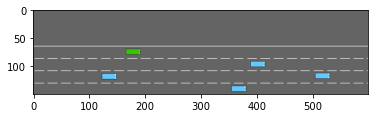

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00 -3.8375147e-02  5.0045484e-01 -6.8339989e-02
   1.0235101e-05]
 [ 1.0000000e+00  1.7187411e-01  7.5000000e-01 -3.5626501e-02
   0.0000000e+00]
 [ 1.0000000e+00  2.0309231e-01  2.5003228e-01 -5.3967029e-02
  -2.0287841e-06]
 [ 1.0000000e+00  3.0822971e-01  4.9981195e-01 -7.2471917e-02
   7.8874080e-05]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


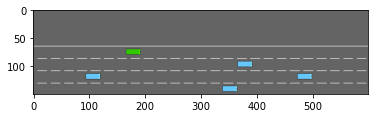

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00  1.5740132e-01  7.5000000e-01 -3.6754847e-02
   0.0000000e+00]
 [ 1.0000000e+00  1.8218815e-01  2.5000426e-01 -5.0638895e-02
  -4.0229852e-06]
 [ 1.0000000e+00  2.7939564e-01  5.0001067e-01 -7.1610540e-02
   1.3706151e-05]
 [ 1.0000000e+00  4.4141567e-01  0.0000000e+00 -4.4240706e-02
   0.0000000e+00]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


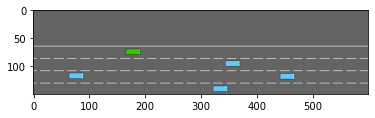

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00  1.4253303e-01  7.5000000e-01 -3.7609164e-02
   0.0000000e+00]
 [ 1.0000000e+00  1.6231610e-01  2.4999844e-01 -4.8787624e-02
   4.5584464e-08]
 [ 1.0000000e+00  2.5093067e-01  5.0000918e-01 -7.0642695e-02
  -3.3839881e-06]
 [ 1.0000000e+00  4.2367512e-01  0.0000000e+00 -4.4489171e-02
   0.0000000e+00]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


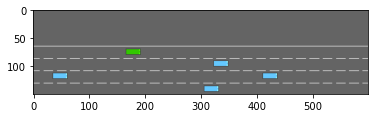

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00  1.2735571e-01  7.5000000e-01 -3.8304582e-02
   0.0000000e+00]
 [ 1.0000000e+00  1.4300101e-01  2.4999976e-01 -4.7839336e-02
   2.0268455e-07]
 [ 1.0000000e+00  2.2285633e-01  4.9999973e-01 -6.9667406e-02
  -7.3481544e-07]
 [ 1.0000000e+00  4.0582457e-01  0.0000000e+00 -4.4791047e-02
   0.0000000e+00]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


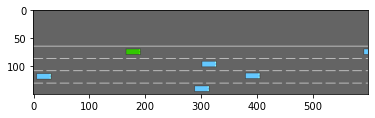

[[ 1.00000000e+00  1.00000000e+00  0.00000000e+00  3.12500000e-01
   0.00000000e+00]
 [ 1.00000000e+00  1.11918196e-01  7.50000000e-01 -3.89133804e-02
   0.00000000e+00]
 [ 1.00000000e+00  1.23954587e-01  2.50000089e-01 -4.74343635e-02
   6.31822150e-10]
 [ 1.00000000e+00  1.95166305e-01  4.99999553e-01 -6.87278882e-02
   1.43110370e-07]
 [ 1.00000000e+00  3.87845665e-01  0.00000000e+00 -4.51318957e-02
   0.00000000e+00]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


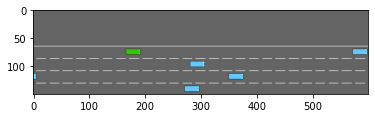

[[ 1.00000000e+00  1.00000000e+00  0.00000000e+00  3.12500000e-01
   0.00000000e+00]
 [ 1.00000000e+00  9.62465703e-02  7.50000000e-01 -3.94770727e-02
   0.00000000e+00]
 [ 1.00000000e+00  1.05004035e-01  2.50000000e-01 -4.73540127e-02
  -1.01608668e-08]
 [ 1.00000000e+00  1.67842686e-01  5.00000000e-01 -6.78401217e-02
   3.84847496e-08]
 [ 1.00000000e+00  3.69724482e-01  0.00000000e+00 -4.55034450e-02
   0.00000000e+00]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


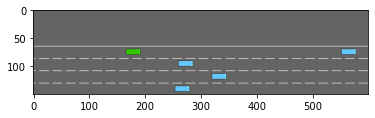

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00  8.0354393e-02  7.5000000e-01 -4.0016886e-02
   0.0000000e+00]
 [ 1.0000000e+00  8.6046174e-02  2.5000000e-01 -4.7467295e-02
  -1.8190272e-10]
 [ 1.0000000e+00  1.4086387e-01  5.0000000e-01 -6.7007668e-02
  -5.9350382e-09]
 [ 1.0000000e+00  3.5144976e-01  0.0000000e+00 -4.5900613e-02
   0.0000000e+00]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


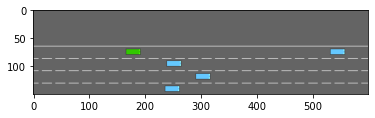

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00  6.4249232e-02  7.5000000e-01 -4.0541694e-02
   0.0000000e+00]
 [ 1.0000000e+00  6.7019455e-02  2.5000000e-01 -4.7696136e-02
   5.0636495e-10]
 [ 1.0000000e+00  1.1420791e-01  5.0000000e-01 -6.6228800e-02
  -1.9814188e-09]
 [ 1.0000000e+00  3.3301193e-01  0.0000000e+00 -4.6319924e-02
   0.0000000e+00]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


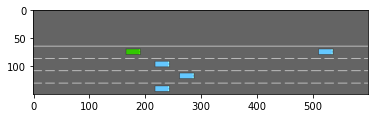

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00  4.7887154e-02  2.5000000e-01 -4.7993880e-02
   1.6771473e-11]
 [ 1.0000000e+00  4.7936585e-02  7.5000000e-01 -4.1053440e-02
   0.0000000e+00]
 [ 1.0000000e+00  8.7854058e-02  5.0000000e-01 -6.5499768e-02
   2.3956948e-10]
 [ 1.0000000e+00  3.1440264e-01  0.0000000e+00 -4.6758734e-02
   0.0000000e+00]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


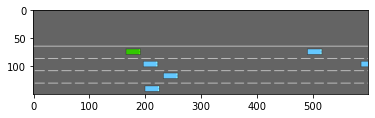

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00  2.8627435e-02  2.5000000e-01 -4.8332367e-02
  -2.5070390e-11]
 [ 1.0000000e+00  3.1421881e-02  7.5000000e-01 -4.1550599e-02
   0.0000000e+00]
 [ 1.0000000e+00  6.1783168e-02  5.0000000e-01 -6.4816296e-02
   1.0067169e-10]
 [ 1.0000000e+00  2.9561454e-01  0.0000000e+00 -4.7214862e-02
   0.0000000e+00]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


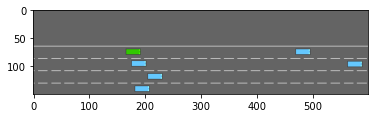

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00  9.2274956e-03  2.5000000e-01 -4.8694298e-02
  -1.2263524e-12]
 [ 1.0000000e+00  1.4711472e-02  7.5000000e-01 -4.2030238e-02
   0.0000000e+00]
 [ 1.0000000e+00  3.5977814e-02  5.0000000e-01 -6.4174205e-02
  -9.2981178e-12]
 [ 1.0000000e+00  2.7664107e-01  0.0000000e+00 -4.7686409e-02
   0.0000000e+00]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


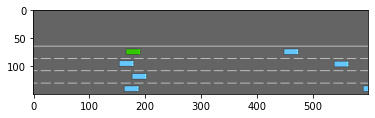

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00 -2.1870281e-03  7.5000000e-01 -4.2489171e-02
   0.0000000e+00]
 [ 1.0000000e+00 -1.0319841e-02  2.5000000e-01 -4.9068742e-02
   1.2325696e-12]
 [ 1.0000000e+00  1.0422169e-02  5.0000000e-01 -6.3569665e-02
  -5.0601745e-12]
 [ 1.0000000e+00  2.5747633e-01  0.0000000e+00 -4.8171729e-02
   0.0000000e+00]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


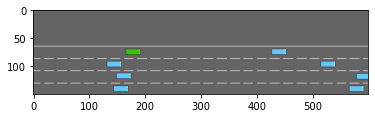

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00 -1.4898139e-02  5.0000000e-01 -6.2999256e-02
   3.3928416e-13]
 [ 1.0000000e+00 -1.9264786e-02  7.5000000e-01 -4.2924523e-02
   0.0000000e+00]
 [ 1.0000000e+00 -3.0018147e-02  2.5000000e-01 -4.9448531e-02
   8.0602192e-14]
 [ 1.0000000e+00  2.3811515e-01  0.0000000e+00 -4.8669372e-02
   0.0000000e+00]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


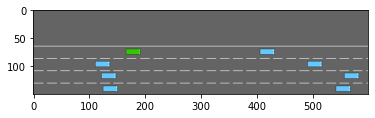

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00 -3.6511920e-02  7.5000000e-01 -4.3334000e-02
   0.0000000e+00]
 [ 1.0000000e+00 -3.9996184e-02  5.0000000e-01 -6.2459953e-02
   2.5202063e-13]
 [ 1.0000000e+00 -4.9868580e-02  2.5000000e-01 -4.9828712e-02
  -6.0174088e-14]
 [ 1.0000000e+00  2.1855278e-01  0.0000000e+00 -4.9178090e-02
   0.0000000e+00]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


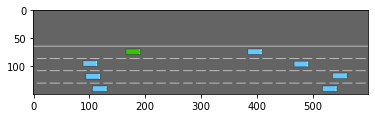

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00  1.9878504e-01  0.0000000e+00 -4.9696792e-02
   0.0000000e+00]
 [ 1.0000000e+00  2.7365965e-01  2.5000000e-01 -5.5541374e-02
   0.0000000e+00]
 [ 1.0000000e+00  3.2065171e-01  7.5000000e-01 -5.3765349e-02
   0.0000000e+00]
 [ 1.0000000e+00  3.3677819e-01  5.0000000e-01 -4.8389804e-02
   4.0856207e-14]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


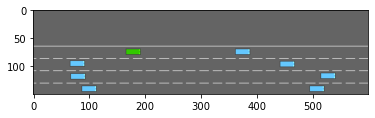

[[ 1.00000000e+00  1.00000000e+00  0.00000000e+00  3.12500000e-01
   0.00000000e+00]
 [ 1.00000000e+00  1.78808093e-01  0.00000000e+00 -5.02245277e-02
   0.00000000e+00]
 [ 1.00000000e+00  2.51401514e-01  2.50000000e-01 -5.57593368e-02
   0.00000000e+00]
 [ 1.00000000e+00  2.99277425e-01  7.50000000e-01 -5.30709289e-02
   0.00000000e+00]
 [ 1.00000000e+00  3.17482442e-01  5.00000000e-01 -4.80702743e-02
   1.26565425e-14]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


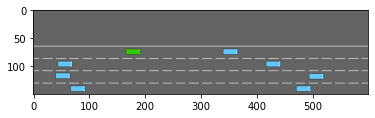

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00  1.5861851e-01  0.0000000e+00 -5.0760422e-02
   0.0000000e+00]
 [ 1.0000000e+00  2.2906123e-01  2.5000000e-01 -5.5950474e-02
   0.0000000e+00]
 [ 1.0000000e+00  2.7816895e-01  7.5000000e-01 -5.2438933e-02
   0.0000000e+00]
 [ 1.0000000e+00  2.9831165e-01  5.0000000e-01 -4.7765695e-02
  -1.9984014e-15]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


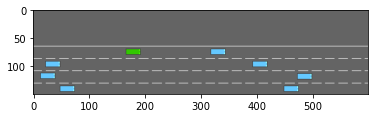

[[ 1.0000000e+00  1.0000000e+00  0.0000000e+00  3.1250000e-01
   0.0000000e+00]
 [ 1.0000000e+00  1.3821317e-01  0.0000000e+00 -5.1303651e-02
   0.0000000e+00]
 [ 1.0000000e+00  2.0664941e-01  2.5000000e-01 -5.6115344e-02
   0.0000000e+00]
 [ 1.0000000e+00  2.5730294e-01  7.5000000e-01 -5.1860999e-02
   0.0000000e+00]
 [ 1.0000000e+00  2.7926010e-01  5.0000000e-01 -4.7475044e-02
  -6.6613381e-16]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


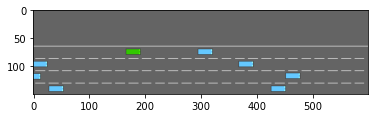

[[ 1.          1.          0.          0.3125      0.        ]
 [ 1.          0.11758929  0.         -0.05185337  0.        ]
 [ 1.          0.18417643  0.25       -0.05625468  0.        ]
 [ 1.          0.23665906  0.75       -0.0513303   0.        ]
 [ 1.          0.2603223   0.5        -0.04719742  0.        ]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


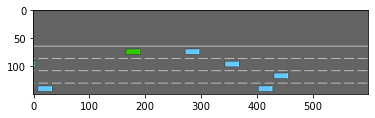

[[ 1.          1.          0.          0.3125      0.        ]
 [ 1.          0.09674446  0.         -0.05240867  0.        ]
 [ 1.          0.16165234  0.25       -0.05636939  0.        ]
 [ 1.          0.21621953  0.75       -0.05084121  0.        ]
 [ 1.          0.24149328  0.5        -0.04693201  0.        ]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


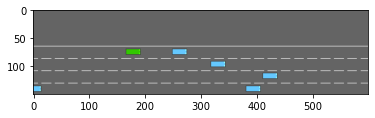

[[ 1.          1.          0.          0.3125      0.        ]
 [ 1.          0.07567661  0.         -0.05296858  0.        ]
 [ 1.          0.13908681  0.25       -0.05646048  0.        ]
 [ 1.          0.19596861  0.75       -0.05038904  0.        ]
 [ 1.          0.22276825  0.5        -0.04667808  0.        ]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


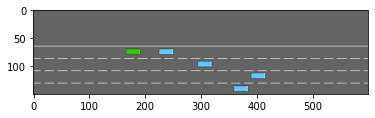

[[ 1.          1.          0.          0.3125      0.        ]
 [ 1.          0.0543841   0.         -0.05353199  0.        ]
 [ 1.          0.11648909  0.25       -0.05652909  0.        ]
 [ 1.          0.17589228  0.75       -0.04996982  0.        ]
 [ 1.          0.20414273  0.5        -0.04643499  0.        ]]

Acción: IDLE -> recommpensa: 0.7999999999999999
Nuevo estado:


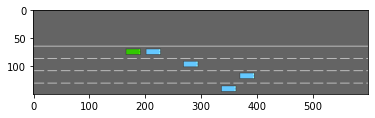

[[ 1.          1.          0.          0.3125      0.        ]
 [ 1.          0.03286577  0.         -0.05409767  0.        ]
 [ 1.          0.09386793  0.25       -0.05657642  0.        ]
 [ 1.          0.15597801  0.75       -0.04958021  0.        ]
 [ 1.          0.18561254  0.5        -0.04620212  0.        ]]

Acción: IDLE -> recommpensa: 0.0
Nuevo estado:


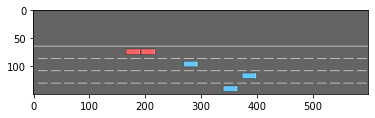

[[ 1.          1.          0.          0.16795039  0.        ]
 [ 1.          0.025       0.         -0.0291961   0.        ]
 [ 1.          0.09383989  0.25        0.08794589  0.        ]
 [ 1.          0.15882277  0.75        0.09533229  0.        ]
 [ 1.          0.18978193  0.5         0.09857069  0.        ]]
Episodio terminado después de 28 pasos y la recompensa fue 21.60000000000001


In [30]:
# Carga del modelo entrenado
modelo = torch.load("DQN.pth")['state_dic']
dqn.load_state_dict(modelo)

obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial:")
plt.imshow(env.render(mode="rgb_array"))
plt.show()
print(obs)

while not done:
    # Obtener la acción y la ejecutamos
    action = dqn.get_action(obs, 0)
    new_obs, reward, done, info = env.step(action)
    
    # Imprimimos el paso
    print("\nAcción: {} -> recommpensa: {}".format(env.action_type.actions[action], reward))
    print("Nuevo estado:")
    plt.imshow(env.render(mode="rgb_array"))
    plt.show()
    env.close()
    print(new_obs)
    
    t += 1
    total_reward += reward
    obs = new_obs
    
print("Episodio terminado después de {} pasos y la recompensa fue {}".format(t, total_reward))